In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sb
import mysql.connector as mysqlc

db = mysqlc.connect(host = "localhost",
                    username = "root",
                    password = "Root",
                    database = "ecomm")

cur = db.cursor()
# extracting data from the mysql database for further analysis 

# 1. List all unique cities where customers are located.

In [12]:
query = """SELECT DISTINCT upper(customer_city)
           FROM customers"""
cur.execute(query)
data = cur.fetchall()
import pandas as pd
df= pd.DataFrame(data,columns=["Cities"])
df



,Cities
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# 2. Count the number of orders placed in 2017.


In [13]:
query = """SELECT COUNT(*) as total_order
        FROM orders
        WHERE year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
data
"Total Orders Placed In 2017 are" ,data[0][0]

('Total Orders Placed In 2017 are', 45101)

# 3. Find the total sales per category.

In [14]:
query = """SELECT DISTINCT upper(products.product_category) as Category,
          round(sum(payments.payment_value),2) as Sales
    FROM products
    JOIN order_items
    ON products.product_id = order_items.product_id
    JOIN payments
    ON payments.order_id = order_items.order_id
    GROUP BY Category"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "Sales"])
df



,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments

In [15]:
query  ="""SELECT (SUM(CASE WHEN payment_installments >=1 THEN 1 ELSE 0 END ))/COUNT(*)*100,2 FROM payments"""
cur.execute(query)
data = cur.fetchall()
"percentage of orders that were paid in installments is", data[0][0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

# 5. Count the number of customers from each state. 

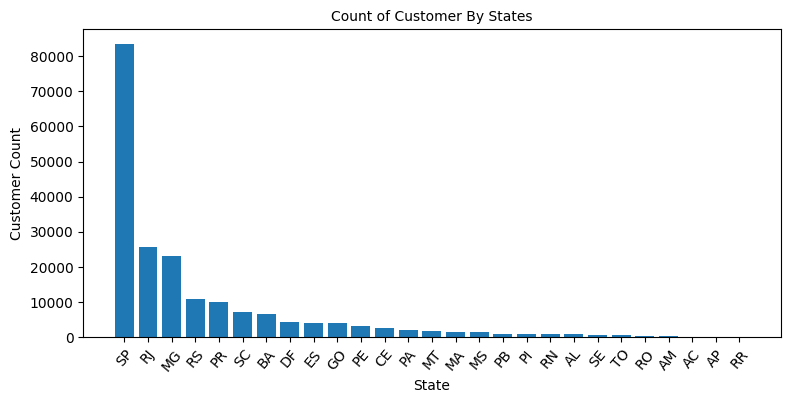

In [16]:
query = """SELECT customer_state, COUNT(customer_id)as Count
            FROM customers
            GROUP BY customer_state;"""
cur.execute(query)
data = cur.fetchall()
import pandas as pd

df = pd.DataFrame(data,columns=["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize= (9,4))
plt.title("Count of Customer By States", fontsize = 10)
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =50)
plt.xlabel("State",fontsize = 10)
plt.ylabel("Customer Count",fontsize = 10)
plt.show()


# 6.Calculate the number of orders per month in 2018.

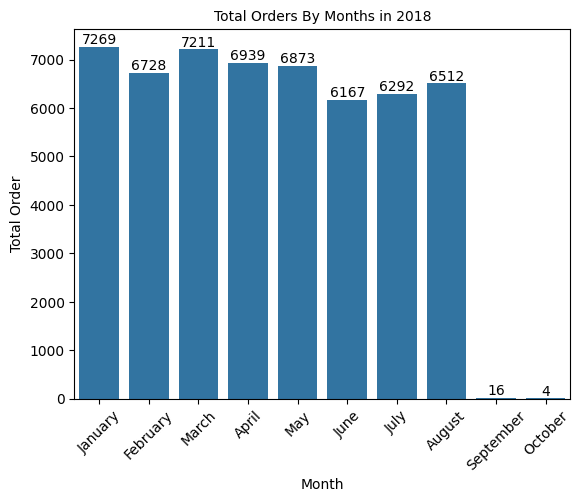

In [17]:
query = """SELECT MONTHNAME(order_purchase_timestamp) as Month, COUNT(order_id) as Total_orders
            FROM orders
            WHERE YEAR(order_purchase_timestamp) = 2018
            GROUP BY Month;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Month","Total Order"])
order = ["January", "February","March","April","May","June","July","August","September","October"]
ax = sb.barplot(x = "Month", y= "Total Order", data = df , order = order)
ax.bar_label(ax.containers[0])

plt.title("Total Orders By Months in 2018", fontsize = 10)
plt.xticks(rotation = 45)
plt.show()


# 7. Find the average number of products per order, grouped by customer city.

In [18]:
query = """with count_per_order as(
select 
orders.order_id as order_id,
orders.customer_id as customer_id,
count(order_items.order_id) as Total_Order
from orders
join order_items
on orders.order_id = order_items.order_id
group by order_id, customer_id)

select 
upper(customers.customer_city) as customer_city,
round(avg(count_per_order.Total_Order),2) as Avg_Orders
from customers
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customer_city
order by Avg_Orders desc"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Customer City","Avg Prod.Per Order"])
df.head(10)

,Customer City,Avg Prod.Per Order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,TEIXEIRA SOARES,4.00
7,CURRALINHO,4.00
8,CIDELANDIA,4.00
9,PICARRA,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.


In [19]:
query = """SELECT 
    upper(p.product_category) AS category,
    ROUND((SUM(pay.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS revenue_percentage
FROM products AS p
JOIN order_items AS oi ON p.product_id = oi.product_id
JOIN payments AS pay ON pay.order_id = oi.order_id
GROUP BY p.product_category
ORDER BY revenue_percentage DESC
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Category","Revenue %"])
df 


,Category,Revenue %
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# 9.Identify the correlation between product price and the number of times a product has been purchased.

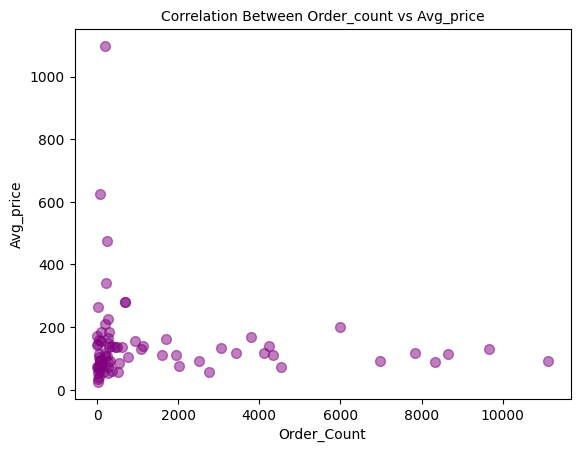

In [28]:
query = """select
upper(products.product_category) as category,
count(order_items.product_id) as Total_count,
round(avg(order_items.price),2) as Avg_price
from products  
join order_items 
on products.product_id = order_items.product_id
group by category"""

cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns=["Product Category","Order_Count","Avg_Price"])
df

arr1 = df["Order_Count"]
arr2 = df["Avg_Price"]

np.corrcoef([arr1,arr2])

plt.scatter(df["Order_Count"],df["Avg_Price"],s = 50, alpha= 0.5, color = "purple")
plt.xlabel("Order_Count", fontsize= 10)
plt.ylabel("Avg_price", fontsize = 10)
plt.title("Correlation Between Order_count vs Avg_price",fontsize = 10)
plt.show()

# from Graph We can conclude that there is no correlation between Order_Count and Avg_price


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [21]:
query = """select *,dense_rank() over(order by revenue desc) as rank_No
from 
(select 
order_items.seller_id as sellers,
round(sum(payments.payment_value),2) as revenue
from order_items
join payments on order_items.order_id= payments.order_id
group by sellers) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Seller_id","Revenue",'Rank'])
df.head(10)

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


# 11. Calculate the moving average of order values for each customer over their order history


In [22]:
query = """select
customer,
Order_Time,
Payment,
avg(payment)
over(partition by customer 
order by Order_Time 
rows between 2 preceding and current row ) as Moving_Avg
from 
(select 
orders.customer_id as Customer, 
orders.order_purchase_timestamp as Order_Time,
payments.payment_value as Payment
from payments
join orders on payments.order_id = orders.order_id ) as OrderDetals;"""

cur.execute(query)
data = cur.fetchall()

df =pd.DataFrame(data,columns=["Customer","Order_Time","Payments","Moving_Avg"])
df.head(10)


,Customer,Order_Time,Payments,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 12. Calculate the cumulative sales per month for each year

In [23]:
query = """select
Year, 
Month,
payment,
sum(payment)
over(order by Year,Month) as Cumulative_Sale 
from 
(select 
year(orders.order_purchase_timestamp) as Year,
month(orders.order_purchase_timestamp) as Month, 
round(sum(payments.payment_value),2)as payment
from orders
join payments on orders.order_id = payments.order_id
group by Year, Month
order by Year, Month)AS Details"""

cur.execute(query)
data = cur.fetchall()

df =pd.DataFrame(data,columns=["Year","Month","Payment","Cumulative_Sales"])
df 

,Year,Month,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


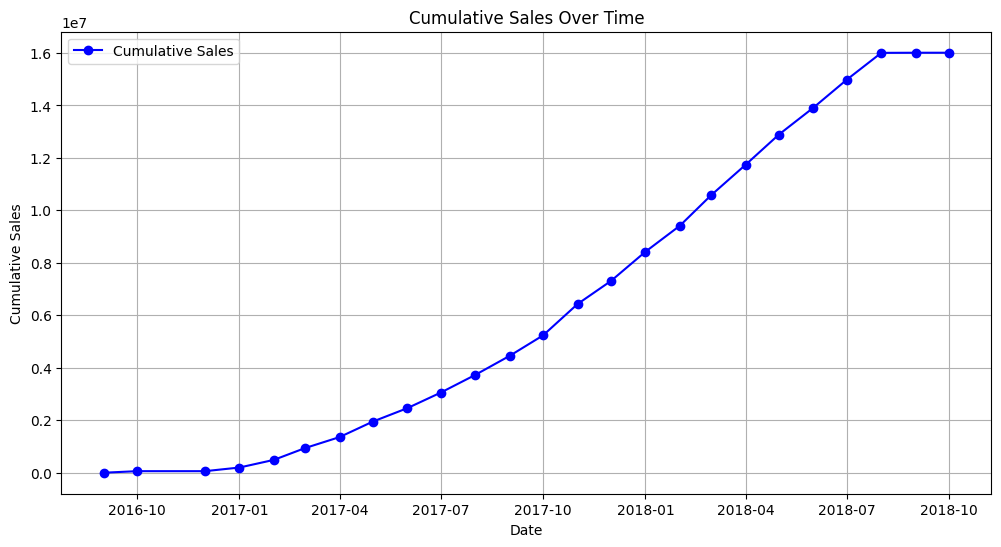

In [24]:
# plotting a Graph for Better Understanding :-

# Convert Year and Month columns to a datetime format for easy plotting
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Set 'Date' as the index for better plotting
df.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Sales'], marker='o', color='b', label='Cumulative Sales')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales Over Time')
plt.legend()
plt.grid(True)
plt.show()


# 13. Calculate the year-over-year growth rate of total sales.

In [25]:
query = """with Previous_sales as (select 
year(orders.order_purchase_timestamp) as Year,
round(sum(payments.payment_value),2) as Sales
from orders
join payments on orders.order_id = payments.order_id
group by Year
order by Year)

select Year,((Sales-lag(sales,1) over(order by Year))/lag(Sales,1) over(order by Year)*100) 
 from Previous_sales"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=["Year","YOY % Change"])
df

,Year,YOY % Change
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14.  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [29]:
query = """WITH first_purchase AS (
SELECT 
customers.customer_id,
MIN(orders.order_purchase_timestamp) AS first_order_date
FROM customers
JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id
),
retained_customer AS (
SELECT
fp.customer_id,
COUNT(DISTINCT orders.order_purchase_timestamp) AS count_repeat_purchase
FROM first_purchase fp
JOIN orders ON fp.customer_id = orders.customer_id
AND orders.order_purchase_timestamp > fp.first_order_date
AND orders.order_purchase_timestamp < DATE_ADD(fp.first_order_date, INTERVAL 6 MONTH)
GROUP BY fp.customer_id
)
SELECT 
100 * (COUNT(DISTINCT retained_customer.customer_id) / COUNT(DISTINCT first_purchase.customer_id)) AS retention_rate
FROM first_purchase 
LEFT JOIN retained_customer ON first_purchase.customer_id = retained_customer.customer_id
WHERE retained_customer.count_repeat_purchase > 0
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ["Retention_Rate"])
df

# Non of our customer is Repeated that the only reason our Retention_Rate is None/0 

,Retention_Rate
0,None


# 15. Identify the top 3 customers who spent the most money in each year.

In [ ]:
query = """
select Year, Customer,payment, D_Rank
from
(select
Year(orders.order_purchase_timestamp) as Year,
orders.customer_id as Customer,
round(sum(payments.payment_value),2) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) AS D_Rank
from orders
join payments on payments.order_id = orders.order_id
group by Year, Customer) as A
where D_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
data 

df = pd.DataFrame(data,columns=["Year","Customer_id","Payment","Rank"])
df

,Year,Customer_id,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3
